<a href="https://colab.research.google.com/github/jake314jake/facial-recognition/blob/main/Global.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/ma7555/keras-vggface.git mtcnn

  Cloning https://github.com/ma7555/keras-vggface.git to /tmp/pip-req-build-i2tofx9j
  Running command git clone --filter=blob:none --quiet https://github.com/ma7555/keras-vggface.git /tmp/pip-req-build-i2tofx9j
  Resolved https://github.com/ma7555/keras-vggface.git to commit 97a512377f9ead550a74595b657c7ec9b8161e75
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.5 MB/s eta 0:00:00
  Created wheel for keras-vggface: filename=keras_vggface-0.7-py3-none-any.whl size=8318 sha256=3f105297ab4b0327f10d4a049017e2b1b583b0fee8263a1df51768d8b7647efe
  Stored in directory: /tmp/pip-ephem-wheel-cache-r_5edzp5/wheels/e3/b0/c4/d248c583f944c032a2429b2c0b4bfba1f24ac9c50ca6692eaf
Successfully built keras-vggface


In [2]:
!sudo apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [6]:
!unrar x "Data.rar"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from Data.rar

Creating    New folder                                                OK
Extracting  New folder/Aaron_Eckhart.png                                   0%  OK 
Extracting  New folder/Aaron_Guiel.png                                     1%  OK 
Extracting  New folder/Aaron_Patterson.png                                 2%  OK 
Extracting  New folder/Aaron_Peirsol.png                                   3%  OK 
Extracting  New folder/Aaron_Pena.png                                      4%  OK 
Extracting  New folder/Aaron_Sorkin.png                                    5%  OK 
Extracting  New folder/Aaron_Tippin.png                                    6%  OK 
Extracting  New folder/Abbas_Kiarostami.png                                7%  OK 
Extracting  New folder/Abba_Eban.png                                       8%  O

In [4]:
import os
import cv2
from mtcnn.mtcnn import MTCNN
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
import h5py
import matplotlib.pyplot as plt

def extract_face(image_path, required_size=(224, 224)):
    pixels = cv2.imread(image_path)
    pixels = cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    face_arrays = []
    bounding_boxes = []

    for i, result in enumerate(results):
        x, y, width, height = result['box']
        x2, y2 = x + width, y + height
        face = pixels[y:y2, x:x2]
        image = Image.fromarray(face)
        image = image.resize(required_size)
        face_array = np.asarray(image)
        face_arrays.append(face_array)

        bounding_boxes.append((x, y, width, height))

    return face_arrays, bounding_boxes


def get_embedding(employee_id, face_pixel):
    # Convert face_pixel into an array of samples and ensure it's in floating-point format
    sample = np.expand_dims(face_pixel.astype('float32'), axis=0)
    sample = preprocess_input(sample, version=2)
    model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    embedding = model.predict(sample)
    return employee_id, embedding


def save_embeddings(embeddings_list, file_path="embedding.h5"):
    try:
        with h5py.File(file_path, 'a') as hf:
            for id, embedding in embeddings_list:
                if id in hf:
                    # Existing dataset, overwrite
                    hf[id][:] = embedding
                else:
                    # Create a new dataset
                    hf.create_dataset(id, data=embedding)
    except Exception as e:
        print(f"Error saving embeddings to HDF5: {e}")

def load_embeddings(file_path="embedding.h5"):
    embeddings = {}
    try:
        with h5py.File(file_path, 'r') as hf:
            for employee_id in hf.keys():
                embedding = np.array(hf[employee_id])
                embeddings[employee_id] = embedding
    except Exception as e:
        print(f"Error loading embeddings from HDF5: {e}")
        return None

    return embeddings

def build(images_directory="Data", hdf5_file_path="embedding.h5"):
    embedding_data = []

    for filename in os.listdir(images_directory):
        image_path = os.path.join(images_directory, filename)

        # Check if the image file exists
        if not os.path.isfile(image_path):
            print(f"Error: Image file not found at {image_path}. Please provide the correct path.")
            continue

        # Check if the image file is a supported format
        try:
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error: Unable to load the image at {image_path}. Please check if it's a valid image file.")
                continue
        except Exception as e:
            print(f"Error: {e}")
            continue

        face_pixels,Box = extract_face(image_path)
        if face_pixels is  None:
            continue

        face_id = os.path.splitext(filename)[0]
        embedding = get_embedding(face_id, face_pixels[0])[1].flatten()

        embedding_data.append((face_id, embedding))

    save_embeddings(embedding_data, hdf5_file_path)


def similarity_function(embedding1, embedding2):
    #normalized_embedding1 = embedding1 / np.linalg.norm(embedding1)
    #normalized_embedding2 = embedding2 / np.linalg.norm(embedding2)
    return cosine_similarity([embedding1], [embedding2])[0][0]

def verify_person(face_pixels, threshold=0.6):
    try:
        result = get_embedding("input_face", face_pixels)
        if result is None or len(result) != 2:
            print("Invalid input face embedding.")
            return None, None

        input_embedding = result[1].flatten()

        stored_embeddings = load_embeddings("embedding.h5")

        if not stored_embeddings:
            print("No stored embeddings available.")
            return None, None

        verification_results = {}
        for id, stored_embedding in stored_embeddings.items():
            similarity = similarity_function(input_embedding, stored_embedding.flatten())
            verification_results[id] = similarity

        verified_employee = None
        max_similarity = max(verification_results.values())
        if max_similarity >= threshold:
            verified_employee = max(verification_results, key=verification_results.get)

        return verified_employee, max_similarity
    except Exception as e:
        print(f"Error during verification: {e}")
        return None, None

def visualize_verification(image_path):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get the face arrays and bounding boxes using the extract_face function
    face_arrays, bounding_boxes = extract_face(image_path, required_size=(224, 224))

    for face_array, (x, y, width, height) in zip(face_arrays, bounding_boxes):
        # Perform face verification for the current face array
        verified_employee, P = verify_person(face_array)

        # Draw a green or red box based on verification result
        color = (0, 255, 0) if verified_employee is not None else (255, 0, 0)
        cv2.rectangle(image, (x, y), (x + width, y + height), color, 2)

        # Add text with employee name
        text = f"Employee: {verified_employee}" if verified_employee is not None else "Unknown"
        print(P)
        cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image with the bounding boxes
    plt.imshow(image)
    plt.axis('off')
    plt.show()




1/1 [==============================] - 1s 952ms/step
0.94253886


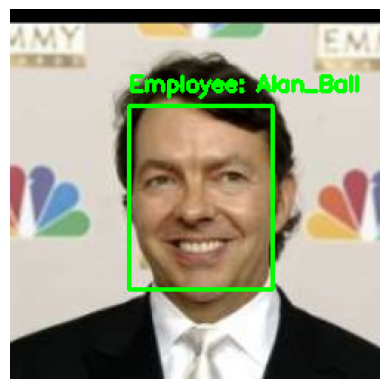

In [17]:
# Example: Building Embeddings, Saving to HDF5, and Verification Visualization

# Step 1: Build Embeddings and Save to HDF5
#build()

# Step 2: Visualize Verification Result for a New Image
new_image_path = "Alan_Ball_0002.jpg"
visualize_verification(new_image_path)

1/1 [==============================] - 0s 106ms/step
[[[165 178 179]
  [132 148 148]
  [ 64  81  81]
  ...
  [ 34  45  37]
  [ 34  44  35]
  [ 41  49  40]]

 [[143 155 156]
  [ 99 113 114]
  [ 39  55  55]
  ...
  [ 30  42  36]
  [ 29  40  33]
  [ 32  42  34]]

 [[112 124 123]
  [ 68  83  81]
  [ 24  40  38]
  ...
  [ 28  39  35]
  [ 26  37  32]
  [ 27  37  33]]

 ...

 [[144 164 163]
  [143 163 165]
  [143 163 165]
  ...
  [154 158 137]
  [156 161 141]
  [155 161 141]]

 [[145 165 164]
  [145 165 164]
  [145 165 164]
  ...
  [149 158 134]
  [153 163 138]
  [153 163 140]]

 [[147 167 166]
  [146 166 165]
  [145 165 164]
  ...
  [146 159 133]
  [151 164 138]
  [150 163 137]]]


In [50]:
print(get_embedding("zinou",extract_face("Data/Zinou.jpg")[0]))

1/1 [==============================] - 1s 862ms/step
('zinou', array([[0.       , 3.6588106, 0.       , ..., 0.6137161, 1.2508699,
        0.       ]], dtype=float32))
